In [1]:
%matplotlib inline

import os
import sys
from itertools import product
import numpy as np
np.set_printoptions(precision=4,suppress=True, linewidth=140)
import scipy

import matplotlib.pyplot as plt

from h5 import HDFArchive
from triqs.gf import *
from triqs.gf.descriptors import Fourier, Omega
from triqs.plot.mpl_interface import plt,oplot
from triqs.lattice.utils import TB_from_wannier90, k_space_path

import solid_dmft.postprocessing.plot_correlated_bands as pcb
import solid_dmft.postprocessing.maxent_sigma as sigma_maxent

Starting serial run at: 2022-05-23 16:02:38.622639


## 7. Comparison to Hubbard-I solution

<i class="fa fa-gear fa-2x" style="color: #186391"></i>&nbsp; 

In [64]:
with HDFArchive('b10-U3.6-hubbardI/lco_wannier.h5','r') as h5:
    print(h5['DMFT_results']['last_iter'])
    # the next two lines load all directly measured observables and the convergence metrics per iteration
    obs = h5['DMFT_results/observables']
    conv_obs = h5['DMFT_results/convergence_obs']
    # The next lines load the last iteration impurity Green function and self-energies
    Sigma_real_freq_hI = h5['DMFT_results/last_iter/Sigma_Refreq_0']
    G_imp_w = h5['DMFT_results/last_iter/Gimp_Refreq_0']
    G_imp_tau = h5['DMFT_results/last_iter/Gimp_time_0']
    # last, the chemical potential and double counting potential
    mu_hI = h5['DMFT_results']['last_iter']['chemical_potential_post']
    dc_hI = h5['DMFT_results']['last_iter']['DC_pot']

HDFArchive with the following content:
  DC_energ : subgroup
  DC_pot : subgroup
  Delta_time_0 : subgroup
  G0_Refreq_0 : subgroup
  G0_freq_0 : subgroup
  Gimp_Refreq_0 : subgroup
  Gimp_freq_0 : subgroup
  Gimp_time_0 : subgroup
  Sigma_Refreq_0 : subgroup
  Sigma_freq_0 : subgroup
  chemical_potential_post : data 
  chemical_potential_pre : data 
  dens_mat_post : subgroup
  dens_mat_pre : subgroup
  full_dens_mat_0 : subgroup
  h_loc_diag_0 : subgroup


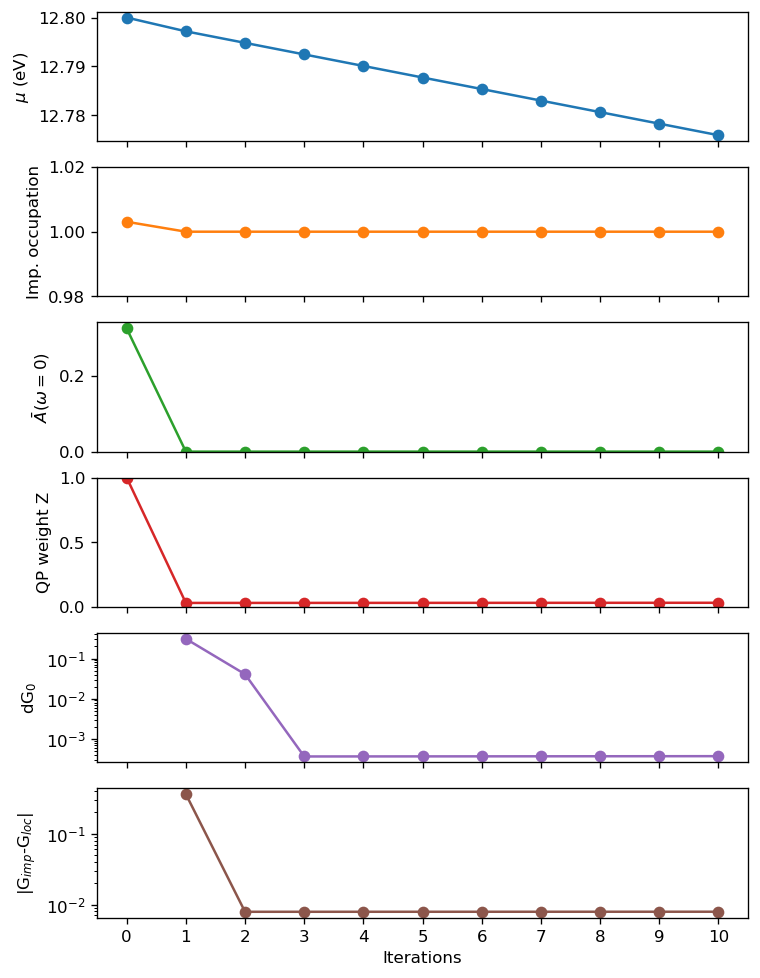

In [59]:
fig, ax = plt.subplots(nrows=6, dpi=120, figsize=(7,10), sharex=True)

# chemical potential
ax[0].plot(obs['iteration'], obs['mu'], '-o', color='C0')
ax[0].set_ylabel(r'$\mu$ (eV)')

# imp occupation
imp_occ = np.array(obs['imp_occ'][0]['up'])+np.array(obs['imp_occ'][0]['down'])
ax[1].plot(obs['iteration'], imp_occ, '-o', color='C1')
ax[1].set_ylim(0.98,1.02)
ax[1].set_ylabel('Imp. occupation')

# A(w=0)
Aw0 = -1*(np.array(obs['imp_gb2'][0]['up'])+np.array(obs['imp_gb2'][0]['down']))
ax[2].plot(obs['iteration'], Aw0 , '-o', color='C2')
ax[2].set_ylim(0,)
ax[2].set_ylabel(r'$\bar{A}(\omega=0$)')

# Z
Z = 0.5*(np.array(obs['orb_Z'][0]['up'])+np.array(obs['orb_Z'][0]['down']))
ax[3].plot(obs['iteration'], Z, '-o', color='C3')
ax[3].set_ylim(0,1.0)
ax[3].set_ylabel(r'QP weight Z')

# convergence of Weiss field
ax[4].semilogy(obs['iteration'][1:], conv_obs['d_G0'][0], '-o', color='C4')
ax[4].set_ylabel(r'dG$_0$')

# convergence of DMFT self-consistency condition Gimp-Gloc
ax[5].semilogy(obs['iteration'][1:], conv_obs['d_Gimp'][0], '-o', color='C5')
ax[5].set_ylabel(r'|G$_{imp}$-G$_{loc}$|')

ax[-1].set_xticks(range(0,len(obs['iteration'])))
ax[-1].set_xlabel('Iterations')

plt.show()

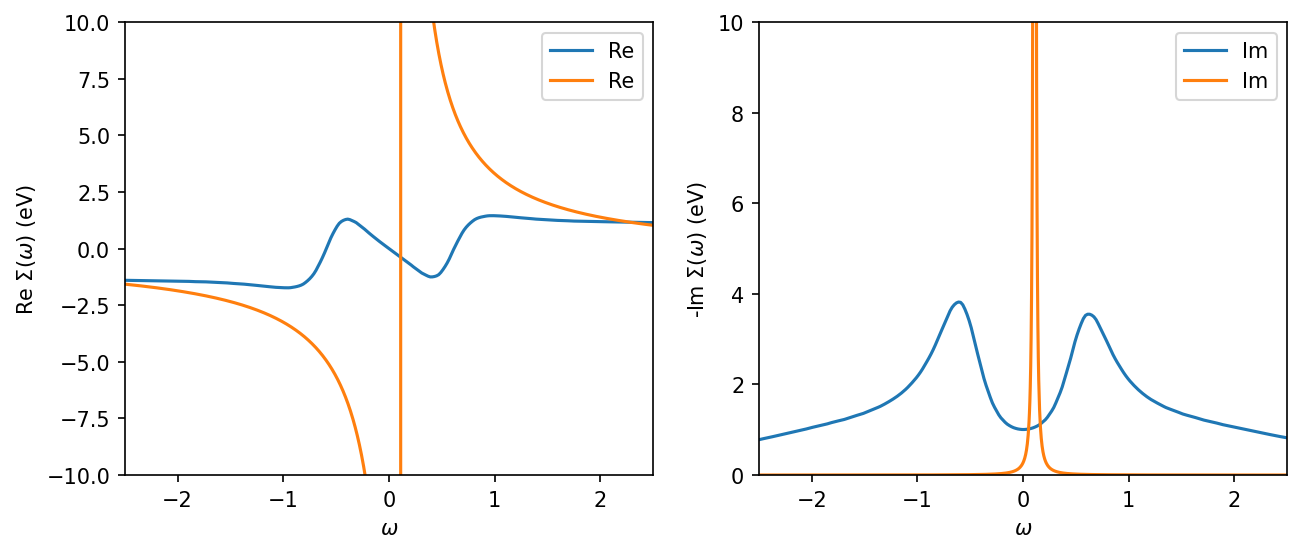

In [62]:
fig, ax = plt.subplots(1,2, sharex=True, dpi=150, figsize=(10,4))

# plot real part of the self-energy and subtract constant offset at 0.0 (Hartree shift)
# Sigma_real_freq['up_0'](0.0) evaluates the self-energy at w=0.0
ax[0].oplot((Sigma_real_freq['up_0'] - Sigma_real_freq['up_0'](0.0)[0,0]).real, '-', c='C0', label='Re')
ax[0].oplot((Sigma_real_freq_hI['up_0'] - Sigma_real_freq_hI['up_0'].data[-1,0,0]).real, '-', c='C1', label='Re')
# plot imaginary part of the self-energy
ax[1].oplot(-1*Sigma_real_freq['up_0'].imag, '-', c='C0', label='Im')
ax[1].oplot(-1*Sigma_real_freq_hI['up_0'].imag, '-', c='C1', label='Im')

ax[0].set_ylabel(r"Re $\Sigma (\omega)$ (eV)")
ax[1].set_ylabel(r"-Im $\Sigma (\omega)$ (eV)")
ax[0].set_ylim(-10,10)
ax[1].set_ylim(0,10)
ax[-1].set_xlim(-2.5,2.5)
plt.show()

In [81]:
dc_hI[0]['down_0'] = dc_hI[0].pop('down')
dc_hI[0]['up_0'] = dc_hI[0].pop('up')

H(R=0):
      0.1589
Setting Sigma from memory


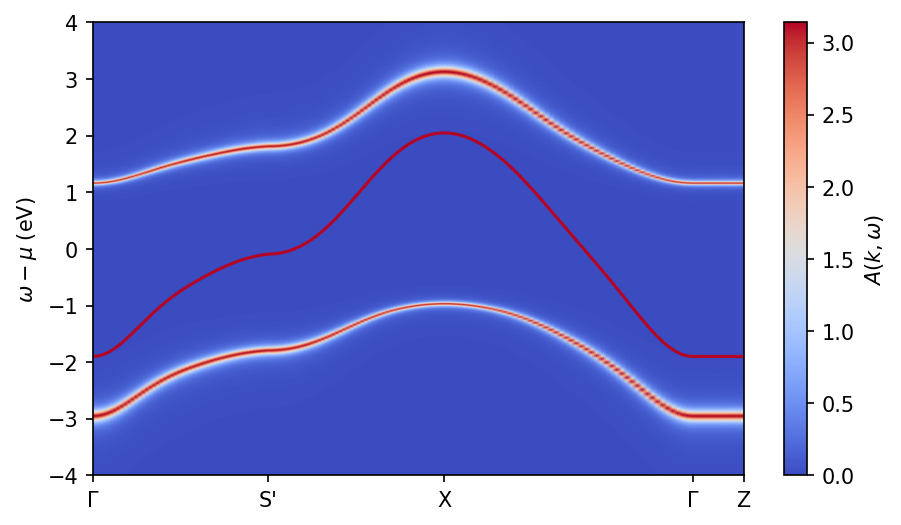

In [89]:
# we have to specify the mesh of the spectral function and pass a new keywargs object sigma_dict
w_mesh = {'window': [-4.0, 4.0], 'n_w': int(501)}
sigma_dict = {'dmft_path': 'b10-U3.6-hubbardI/lco_wannier.h5', 'it': 'last_iter', 'orbital_order_dmft': [0], 'spin': 'up_0', 'eta': 0.1,
              'block' : 0 ,'w_mesh': w_mesh, 'linearize': False, 'dc': dc_hI, 'dmft_mu': mu_hI-obs['mu'][0]}

tb_bands_data, alatt_k_w_path, freq_dict, dft_mu = pcb.get_dmft_bands(orbital_order_to = [0], with_sigma=Sigma_real_freq_hI, **w90_dict, **tb_bands, **sigma_dict)

fig, ax = plt.subplots(1,dpi=150,figsize=(7,4))
pcb.plot_bands(fig, ax, alatt_k_w_path, tb_bands_data, freq_dict, n_orb=w90_dict['n_orb'], dft_mu=0.0, tb=True, alatt=True, **plot_dict)